<div style="border: 1px solid maroon; border-radius: 10px; padding: 20px; text-align: center;">
  <h1 style="color: #194468; font-size: 1.8em; margin: 0;">
    Data Drift Metrics<br>
    Interactive Visualization
  </h1>
</div>


<div style="border-radius:10px; border:maroon; padding:15px; background-color:#f1d5c9; font-size:110%; text-align:left;">
  <h3 style="color:#194468;">Hi, fellow Kaggler!</h3>
  <p style="color:#194468; font-size:110%;">
    I've been exploring metrics for detecting data drift and realized that I needed visualizations. So I created some — and decided to share.
    <br>
    This notebook walks you through the <strong>math</strong>, <strong>code</strong>, and <strong>interactive visualizations</strong> for four key metrics: Wasserstein Distance, Kolmogorov–Smirnov Test, Population Stability Index (PSI), and Jensen–Shannon Distance.
    <br>
    At the end of the notebook, you'll find a panel where you can <strong>play with sliders</strong> to see how changes in distribution parameters affect the metrics. This can be useful in a practical sense too: just plug in parameters from one of your real features and observe how each metric captures the drift.
    <br>
    Following the code may be helpful to build an algorithmic understanding of the metrics. And the math gives a solid formal grounding.
    <br>
    Scroll down for my conclusions.
  </p>
  <p style="color:#194468; font-weight:bold; font-size:90%; margin-top:10px;">
    NB: You need to run the kernel to enjoy the interactive visualizations.
  </p>
</div>

* [Wasserstein Normed Distance](#wasserstein-distance)
* [Kolmogorov-Smirnov Statistic](#kolmogorov-smirnov)
* [Population Stability Index](#psi)
* [Jensen–Shannon Distance](#js-distance)    
* [Interactive Visualization](#interactive-visualization)
* [Conclusions](#conclusions)

In [1]:
import numpy as np
from scipy.stats import entropy, ks_2samp, skewnorm

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from typing import Literal

from ipywidgets import interact, FloatSlider, IntSlider, Layout, Dropdown

In [2]:
class FeatureGenerator:
    """
    Parent class for further metrics.
    Generates synthetic feature distributions for train and current data
    """

    def __init__(
        self,
        train_mean: float,
        train_std: float,
        train_size: int,
        current_mean: float,
        current_std: float,
        current_size: int,
        distribution: Literal["normal", "skewed"],
        **kwargs,
    ):
        self.train_mean = train_mean
        self.train_std = train_std
        self.train_size = train_size

        self.current_mean = current_mean
        self.current_std = current_std
        self.current_size = current_size

        self.distribution = distribution

        self.train = self.feature_generator(
            mean_=train_mean, std_=train_std, size=train_size, distribution="normal"
        )
        self.current = self.feature_generator(
            mean_=current_mean,
            std_=current_std,
            size=current_size,
            distribution=distribution,
            **kwargs,
        )

    @staticmethod
    def feature_generator(
        mean_: float,
        std_: float,
        size: int,
        distribution: Literal["normal", "skewed"] = "normal",
        **kwargs,
    ) -> np.ndarray:
        """
        Generates a synthetic feature distribution.
        """
        np.random.seed(0)
        if distribution == "normal":
            return np.random.normal(loc=mean_, scale=std_, size=size)
        elif distribution == "skewed":
            skew = kwargs.get("skew", 4)
            return np.array(skewnorm.rvs(a=skew, loc=mean_, scale=std_, size=size))
        else:
            raise ValueError(f"Unsupported distribution type: {distribution}")


In [3]:
class FeatureGeneratorWhithBins(FeatureGenerator):
    """
    Generates binned distributions from synthetic train and current datasets,
    and computes normalized histograms for drift metrics.
    """
    def __init__(self, n_batches: int, **kwargs):
        super().__init__(**kwargs)
        self.n_batches = n_batches
        self.bins = np.linspace(
            start=min(self.train), stop=max(self.train), num=self.n_batches + 1
        )
        self.train_ratio = self.calculate_ratio(self.train, self.bins)
        self.current_ratio = self.calculate_ratio(self.current, self.bins)

    def calculate_ratio(self, data: np.ndarray, bins: np.ndarray) -> np.ndarray:
        """
        Calculates the proportion of observations in each bin with protection against zero values.
        These are normalized histograms: the sum of the values across bins equals 1.

        Parameters:
        ----------
        - data: A one-dimensional array of values for which bin proportions need to be calculated.
        - bins: An array of bin edges used to split the value range into intervals.

        Returns:
        ----------
        - A normalized array of proportions per bin, where zero entries are replaced with 1e-6 
          (to avoid issues like division by zero or log of zero), and the result is re-normalized to sum to 1.
        """
        counts, _ = np.histogram(data, bins=bins, density=False)
        ratio = counts / len(data)
        zero_protected = np.clip(ratio, 1e-6, None)
        zero_protected /= zero_protected.sum()
        return zero_protected

<div style="border: 1px solid maroon; border-radius: 10px; padding: 15px; background-color: #f1d5c9; font-size: 110%;">
  <h1 style="color: #194468; text-align: center; margin: 0;">
    I. Wasserstein Distance
  </h1>
  <h2 style="color: #531316; text-align: center; margin-top: 5px; font-weight: normal; font-size: 1.2em;">
    (Earth Mover's Distance)
  </h2>
</div>

### Wasserstein Distance
$$
W_1^{\text{norm}}(T, C) = \frac{1}{b - a} \int_0^1 \left| F_T^{-1}(u) - F_C^{-1}(u) \right| \, du
$$

$$
W_1^{\text{norm}}(T, C) \in [0,\ 1]
$$

where:
- $F_T^{-1}(u)$ — quantile function (inverse CDF) of the TRAINING dataset  
- $F_Q^{-1}(u)$ — quantile function (inverse CDF) of the CURRENT dataset  
- $u \in [0, 1]$ — probability level  
- $[a, b]$ — support range: from min to max across both distributions  
- $W_1^{\text{norm}}(P, Q)$ — normalized Wasserstein distance representing the average shift in quantiles, scaled by the support range

Logic:
- Measures the geometric distance between quantile functions (inverse CDFs) of two distributions
- The normalized version divides the Wasserstein distance by the scale
- Unlike PSI it does not require binning — it operates directly on continuous distributions via their CDFs.

Application in Evidently:
 - only numerical
 - default method for numerical data, if > 1000 objects

In [4]:
class Wasserstein(FeatureGenerator):
    """
    Computes the normalized 1st Wasserstein distance (Earth Mover's Distance)
    between train and current synthetic distributions using inverse ECDFs.
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.common_x = self.make_common_space()

        # Inverse ECDF (quantile function)
        self.train_iecdf = self.make_iecdf(self.train, self.common_x)
        self.current_iecdf = self.make_iecdf(self.current, self.common_x)
        self.value = self.wasserstein()

    def make_common_space(self):
        """
        Returns a uniformly spaced array over [0, 1] with length equal to the size
        of the larger of the two datasets.
        """
        return np.linspace(0, 1, max(self.current_size, self.train_size))

    @staticmethod
    def make_iecdf(data: np.ndarray, common_x: np.ndarray) -> np.ndarray:
        """
        Returns:
        -------
        - the quantile function values (inverse ECDF) interpolated on a shared scale.

        Logic:
        -----
        - Aligns two distributions on a shared [0, 1] probability axis.
        - np.interp is used to interpolate:
            - x: the desired points to evaluate the function on
            - xp: known points
            - fp: function values for known points
        """
        return np.interp(
            x=common_x,
            xp=np.linspace(0, 1, len(data), endpoint=False),
            fp=np.sort(data),
        )

    def wasserstein(self) -> float:
        """
        Computes the normalized Wasserstein distance

        Logic:
        -----
        - The distance is the average absolute difference between
          the inverse ECDFs (quantile functions) over the full [0, 1] range.

        - The result is scaled by the feature value range to ensure the final value lies in [0, 1].
        """
        wass = np.mean(np.abs(self.train_iecdf - self.current_iecdf))
        scale = max(self.train.max(), self.current.max()) - min(
            self.train.min(), self.current.min()
        )
        return float(wass / scale) if scale else 0.0

<div style="border: 1px solid maroon; border-radius: 10px; padding: 15px; background-color: #f1d5c9; font-size: 110%;">
  <h1 style="color: #194468; text-align: center; margin: 0;">
    II. Kolmogorov–Smirnov Test
  </h1>
</div>

### Kolmogorov-Smirnov

$$
D_{T, C} = \sup_x \left| F_T(x) - F_ C(x) \right|
$$

$$
D_{T, C} \in [0,\ 1]
$$

where:
- $F_T(x)$ — empirical cumulative distribution function (ECDF) of the TRAINING dataset 
- $F_C(x)$ — ECDF of the CURRENT dataset   
- $D_{T, C}$ — the maximum vertical distance between the two ECDFs

Logic:
- Measures the max distance between Empirical CDFs of two distributions
- Comes with p-value that defines the drift score (=< 0.05 means drift)

Application in Evidently:
 - numerical (n_unique > 5) for <= 1000 objects

In [5]:
class KS(FeatureGenerator):
    """
    Computes the Kolmogorov–Smirnov (KS) statistic and p-value between two distributions.
    Measures the maximum absolute difference between their empirical CDFs.
    """
    def __init__(self, **kwargs):
        """        
        Attributes:
        -----------
        - all_uniques: Combined sorted array of all unique values from both datasets (X-axis)
        - ks_statistic: Maximum absolute difference between ECDFs (KS statistic)
        - p_value: Significance level of the difference
        """
        super().__init__(**kwargs)
        self.all_uniques = np.sort(
            np.unique(np.concatenate([self.train, self.current]))
        )
        self.train_ecfd = self.make_ecdf(self.train)
        self.current_ecfd = self.make_ecdf(self.current)
        self.value = np.max(np.abs(self.train_ecfd - self.current_ecfd))
        self.p_value = self.ks_p_value()

    def ks_p_value(self) -> np.float64:
        """
        P-value for the KS test.
        """
        _, pval = ks_2samp(self.train, self.current) # Sorry, I was too lazy to write my own code and used scipy's function
        return pval  # type: ignore

    def make_ecdf(self, data: np.ndarray) -> np.ndarray:
        """
        Computes the empirical cumulative distribution function (ECDF) of the given data,
        evaluated at all unique values from both train and current datasets.

        Explanation:
        ------------
        - np.searchsorted returns the indices where elements of all_uniques should be inserted
          into the sorted data array to maintain order.
        - Using "side=right" ensures that duplicate values are counted correctly (ECDF includes them).
        - The result is normalized by dividing by the number of elements in the data array,
          yielding values in the range [0, 1], which is the ECDF.

        Returns:
        --------
        - A NumPy array of ECDF values evaluated at each point in self.all_uniques.
        """
        sorted_data = np.sort(data)

        return np.searchsorted(a=sorted_data, v=self.all_uniques, side="right") / len(
            sorted_data
        )

<a id="psi"></a>
<div style="border: 1px solid maroon; border-radius: 10px; padding: 15px; background-color: #f1d5c9; font-size: 110%;">
  <h1 style="color: #194468; text-align: center; margin: 0;">
    III. Population Stability Index
  </h1>
</div>

### PSI
$$
\text{PSI} = \sum_{i=1}^{n} \left( \text{Train}_i - \text{Current}_i \right) \cdot \ln \left( \frac{\text{Train}_i}{\text{Current}_i} \right)
$$

$$
\text{PSI} \in [0,\ \infty)
$$

where:
- $Train_i$ — mean in i-bin of train data
- $Current_i$ — mean in i-bin of current data
- $n$ — number of bins

Logic:
- Quantifies the distribution shift between two vectors by comparing their proportions across predefined bins
- It is calculated using a logarithmic formula that emphasizes both magnitude and direction of change.
- Binning is required, and the quality of the metric can depend on the number and boundaries of the bins.
- PSI is particularly sensitive to small proportions

**NB: Check how close it is to Kullback-Leibler Divergence (see below in Jensen-Shannon section)**

In [6]:
class PSI(FeatureGeneratorWhithBins):
    """
    Calculates the Population Stability Index (PSI)
    It is computed as the sum of per-bin contributions:
    (p_i - q_i) * log(p_i / q_i)
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.bins_contribution = self.calculate_psi_values(
            self.train_ratio, self.current_ratio
        )
        self.value = float(np.sum(self.bins_contribution))

    @staticmethod
    def calculate_psi_values(train_ratio, current_ratio) -> float:
        """
        Vectorized calculation of PSI (Population Stability Index) contributions per bin.

        Parameters:
        -----------
        - train_ratio: numpy array of normalized frequencies in each bin for the TRAINING dataset.
        - current_ratio: numpy array of normalized frequencies in each bin for the CURRENT dataset.
        """
        return (train_ratio - current_ratio) * np.log(train_ratio / current_ratio)

<a id="ksd"></a>
<div style="border: 1px solid maroon; border-radius: 10px; padding: 15px; background-color: #f1d5c9; font-size: 110%;">
  <h1 style="color: #194468; text-align: center; margin: 0;">
    IV. Jensen–Shannon Distance
  </h1>
</div>

### JS Distance

To understand this metric, let’s walk through the sequence of concepts that build up to it.

-------------------------------------------------------------
1. **Entropy**: 
    $$ H(p) = -\sum_i p_ilog_2(p_i) $$
    
    **Where**:
    - $p$ is a probability of event $i$
    
    **Intuition**: 
    - entropy is the expected value of information
------------------------------------------------------------

2. **Cross Entropy**:
    $$ H(p, q) = -\sum_i p_ilog_2(q_i) $$
    
    **Where**:
    - $p$ is the true distribution  
    - $q$ is the estimated (model) distribution  
    
    **Intuition**
    - How many bits are needed to encode events from $p$ using $q$ 
------------------------------------------------------------

3. **KLD Kullback–Leibler Divergence**:
    $$ D_{\mathrm{KL}}(p \parallel q) = \sum_i p_ilog_2(\frac{p_i}{q_i})$$
    $$ = \sum_i p_ilog_2(p_i) -\sum_i p_ilog_2(q_i)$$
    $$ = H(p,q) - H(p)$$
    
    **Intuition**:
    - Kullback–Leibler Divergence measures the difference between Cross Entropy and Entropy. 
    - It equals zero only when the two distributions are identical, and is strictly positive otherwise.
    - **NB: See how PSI only develops this concept one step further**
------------------------------------------------------------

4. **Mixture Distribution**:
    $$ \vec{m} = \frac{\vec{p} + \vec{q}}{2} $$
    
    **Intuition**:
    - $\vec{m}$ is the average (mixture) distribution  
    - acts as a symmetric reference between $\vec{p}$ and $\vec{q}$ 
------------------------------------------------------------

5. **Jensen–Shannon Divergence**:
    $$D_{\mathrm{JS}}(\vec{p} \parallel \vec{q}) = \frac{D_{\mathrm{KL}}(\vec{p} \parallel \vec{m}) + D_{\mathrm{KL}}(\vec{q} \parallel \vec{m})}{2}$$

   **Where**:
    - $\vec{m}$ is the mixture distribution  
    
   **Intuition**: 
    - symmetric, smoothed version of KL Divergence 
    - avoids infinite values and handles zero probabilities gracefully
------------------------------------------------------------

6. **Jensen–Shannon Distance**:
    $$ \text{Jensen–Shannon distance} = \sqrt{D_{\mathrm{JS}}(\vec{p} \parallel \vec{q})} $$

   **Properties**: 
    - The metric lies within the range [0, 1] and is symmetric
    
   **Intuition**: 
    - When calculating KLD, we took base-2 logarithms of probabilities in [0, 1], which is similar to squaring.
    - Taking the square root brings the values back into the [0, 1] range

In [7]:
class JansenShannon(FeatureGeneratorWhithBins):
    """
    Computes Jensen–Shannon Distance between two distributions 
    using histogram binning.

    Based on averaging Kullback–Leibler divergences from each 
    distribution to the mean distribution. Provides both the 
    overall distance and per-bin contributions.
    """
    def __init__(self, **kwargs):
        """
        self.M — the "mean" distribution
        """
        super().__init__(**kwargs)
        self.M = 0.5 * (self.train_ratio + self.current_ratio)
        self.value = self.compute_js_distance()
        self.jsd_contrib = self.compute_bin_contributions()

    def compute_js_distance(self) -> float:
        """
        Compute Jensen–Shannon distance between the train and current distributions.

        1. Compute the "mean" distribution:
            - We already have normalized histograms where each bin contains the share of entries.
            - These values are averaged between the two histograms (element-wise mean).
            - Distances from this "mean" distribution are used in the metric.

        2. Compute the Kullback–Leibler divergence between each distribution and the mean:
            >>> stats.entropy(p) -> computes Shannon Entropy
            >>> stats.entropy(p, q) -> computes Kullback–Leibler divergence (a.k.a. relative entropy)
            >>> Note: KLD is conceptually the difference between cross-entropy and entropy
                (always ≥ 0, equals 0 only when the distributions are identical).
                KLD = H(p, q) - H(p)
                KLD = -sum(p * log(q)) + sum(p * log(p))
                KLD = sum(p * log(p/q))

        3. Compute Jensen–Shannon divergence as the average of the two KLDs:
            >>> JSD = 0.5 * (KL(train || M) + KL(current || M))

        4. Convert divergence to Jensen–Shannon distance:
            >>> The metric is bounded in [0, 1] and symmetric.
            >>> Intuition: since we take base-2 logarithms of probabilities in [0,1], 
                it's like squaring; taking the square root returns values to the [0,1] range.
        """

        kld_train = entropy(self.train_ratio, self.M, base=2)
        kld_current = entropy(self.current_ratio, self.M, base=2)

        js_divergence = 0.5 * (kld_train + kld_current)
        js_distance = np.sqrt(js_divergence)
        return float(js_distance)

    def compute_bin_contributions(self) -> np.ndarray:
        """
        Compute per-bin contributions to the Jensen–Shannon divergence.

        Returns:
        ---------
        - A NumPy array of length `n_bins`, containing the contribution of each bin to the JSD:
            >>> JSD (per bin) = 0.5 * (p * log2(p / M) + q * log2(q / M))
        """
        kl_pm = self.train_ratio * np.log2(self.train_ratio / self.M)
        kl_qm = self.current_ratio * np.log2(self.current_ratio / self.M)
        return 0.5 * (kl_pm + kl_qm)

<a id="viz"></a>
<div style="border: 1px solid maroon; border-radius: 10px; padding: 15px; background-color: #f1d5c9; font-size: 110%;">
  <h1 style="color: #194468; text-align: center; margin: 0;">
    Interactive Visualization
  </h1>
</div>

In [8]:
class Visualizer:
    def __init__(self, **kwargs):
        self.psi = PSI(**kwargs)
        self.wass = Wasserstein(**kwargs)
        self.ks = KS(**kwargs)
        self.jsd = JansenShannon(**kwargs) 

    def plot_psi(self, ax: Axes):
        ax.bar(["PSI"], [self.psi.value], color='skyblue')
        ax.set_ylim(-0.5, 50)
        ax.axhline(0.25, color='red', linestyle='--', label='PSI = 0.25 - threshold for significant drift')
        ax.text(0, self.psi.value + 0.2, f'{self.psi.value:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')
        ax.set_title("PSI (Population Stability Index)")
        ax.set_ylim(0, 20)
        ax.legend()

    def plot_psi_bins(self, ax: Axes):
        bin_centers = (self.psi.bins[:-1] + self.psi.bins[1:]) / 2
        width = (self.psi.bins[1] - self.psi.bins[0]) * 0.4
        ax.bar(bin_centers - width / 2, self.psi.train_ratio, width=width, label='Train', alpha=0.7, color='skyblue')
        ax.bar(bin_centers + width / 2, self.psi.current_ratio, width=width, label='Current', alpha=0.7, color='orange')
        ax.plot(bin_centers, self.psi.bins_contribution, label='PSI Contribution', color='purple', linewidth=2.5, marker='o', markersize=6)
        ax.set_title("Bin-wise Distribution and PSI Contributions")
        ax.set_xlabel("Feature values (binned)")
        ax.set_ylabel("Share of observations")
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.legend()
    
    def plot_js(self, ax: Axes):
        ax.bar(["JSD"], [self.jsd.value], color='lightgreen')
        ax.axhline(0, color='gray', linestyle='--')
        ax.axhline(0.1, color='red', linestyle='--', label='JSD = 0.1 - statistical significance threshold')
        ax.text(0, self.jsd.value + 0.02, f'{self.jsd.value:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')
        ax.set_title("Jensen-Shannon Distance")
        ax.set_ylim(0, 2)
        ax.legend()
    
    def plot_jsd_bins(self, ax: Axes):
        bin_centers = (self.jsd.bins[:-1] + self.jsd.bins[1:]) / 2
        width = (self.jsd.bins[1] - self.jsd.bins[0]) * 0.4  
        ax.bar(bin_centers - width / 2, self.jsd.train_ratio, width=width, label='Train', alpha=0.5, color='skyblue')
        ax.bar(bin_centers + width / 2, self.jsd.current_ratio, width=width, label='Current', alpha=0.5, color='orange')
        ax.plot(bin_centers, self.jsd.jsd_contrib, label='JSD Contribution', color='purple', linewidth=2.5, marker='o', markersize=6)
        ax.set_title("Per-bin Contribution to Jensen–Shannon Divergence")
        ax.set_xlabel("Feature values (binned)")
        ax.set_ylabel("Contribution to divergence")
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.legend()

    def plot_wasserstein(self, ax: Axes):
        ax.bar(["W1"], [self.wass.value], color='lightgreen')
        ax.axhline(0, color='gray', linestyle='--')
        ax.axhline(0.1, color='red', linestyle='--', label='EMD = 0.1 - threshold for significant drift')
        ax.text(0, self.wass.value + 0.02, f'{self.wass.value:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')
        ax.set_title("W1 (Wasserstein Distance) / EMD (Earth Mover's Distance)")
        ax.set_ylim(0, 2)
        ax.legend()
    
    def plot_wasserstein_geom(self, ax: Axes):       
        ax.plot(self.wass.common_x, self.wass.train_iecdf, label='Train IECDF', color='blue')
        ax.plot(self.wass.common_x, self.wass.current_iecdf, label='Current IECDF', color='orange')
        ax.fill_between(self.wass.common_x, self.wass.train_iecdf, self.wass.current_iecdf, color='lightcoral', alpha=0.4, label='|Train - Current|')
        ax.set_title("Difference of IECDFs")
        ax.set_xlabel("Probability (quantiles)")
        ax.set_ylabel("Feature value")
        ax.grid(True)
        ax.legend()

    def plot_ks(self, ax: Axes):
        ax.bar(["KS"], [self.ks.value], color='lightgreen')
        ax.plot(["KS"], [self.ks.p_value], marker='o', color='purple', markersize=8, label='p-value')
        ax.axhline(0, color='gray', linestyle='--')
        ax.axhline(0.05, color='red', linestyle='--', label='P-value = 0.05 - statistical significance threshold')
        ax.text(0, self.ks.value + 0.02, f'{self.ks.value:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')
        ax.text(0, float(self.ks.p_value) + 0.02, f'{self.ks.p_value:.2e}', ha='center', va='bottom', fontsize=9, fontweight='bold', color='purple')
        ax.set_title("KS (Kolmogorov–Smirnov)")
        ax.set_ylim(0, 2)
        ax.legend()

    def plot_ks_geom(self, ax: Axes):       
        ax.plot(self.ks.all_uniques, self.ks.train_ecfd, label='Train ECDF', color='blue')
        ax.plot(self.ks.all_uniques, self.ks.current_ecfd, label='Current ECDF', color='orange')
        ax.fill_between(self.ks.all_uniques, self.ks.train_ecfd, self.ks.current_ecfd, color='lightcoral', alpha=0.4, label='|Train - Current|')
        ax.set_title("Difference of ECDFs")
        ax.set_xlabel("Feature values (normalized)")
        ax.set_ylabel("Probability")
        ax.grid(True)
        ax.legend()
    
    def visualize(self, **kwargs):
        """ 
        Renders all metric plots.
        """
        _, axs = plt.subplots(
            nrows=4,
            ncols=2, 
            figsize=(12, 15), 
            gridspec_kw={"width_ratios": [1, 1.5]},
            constrained_layout=True
        )

        # Row 1: PSI
        ax1, ax2 = axs[0]
        self.plot_psi(ax1)
        self.plot_psi_bins(ax2)
        
        # Row 2: Jensen–Shannon
        ax3, ax4 = axs[1]
        self.plot_js(ax3)
        self.plot_jsd_bins(ax4)

        # Row 3: Wasserstein
        ax5, ax6 = axs[2]
        self.plot_wasserstein(ax5)
        self.plot_wasserstein_geom(ax6)

        # Row 4: Kolmogorov–Smirnov
        ax7, ax8 = axs[3]
        self.plot_ks(ax7)
        self.plot_ks_geom(ax8)

        plt.show()

### Interactive Visualization

This tool allows you to explore and understand four popular data drift metrics:
PSI, Jensen–Shannon Distance, Wasserstein Distance (EMD), and Kolmogorov–Smirnov Statistic.

**Parameters**
Use the sliders and dropdowns to generate synthetic training and current feature distributions.
You can modify:
- **Distribution Type**: Choose between normal or skewed (for current data).
- **Distribution Shift**: Controls the skew direction of the distribution.
- **Number of Bins**: Affects how metrics like PSI and JSD bucket the data.
- **Sample Sizes**: Size of the training and current datasets.
- **Mean / Standard Deviation**: for both training and current distributions.

**Visual Output**
The visualizer will render 4 rows of plots:
- PSI (Population Stability Index):
    > - Bar with overall PSI value.
    > - Histogram showing two distributions and bin-level contribution plot.

- Jensen–Shannon Distance:
    > - Overall distance bar.
    > - Histogram showing two distributions and bin-level contribution plot.

- Wasserstein Distance:
    > - Bar with normalized EMD (Earth Mover’s Distance).
    > - IECDF difference plot (geometric intuition of “mass transportation”).

- Kolmogorov–Smirnov Statistic:
    > - Bar with KS statistic and corresponding p-value.
    > - ECDF difference plot (maximum vertical distance between distributions).

In [9]:
l = Layout(width='1000px')
style = {'description_width': '200px'}

def run_visualizer (**kwargs):
    viz = Visualizer(**kwargs)
    return viz.visualize(**kwargs)

interact(
    run_visualizer,
    distribution = Dropdown(options=['normal', 'skewed'], value='skewed', description='Distribution:'),
    skew = IntSlider(value=10, min=-10, max=10, step=1, description='Distribution shift', layout = l, style = style),

    n_batches = IntSlider(value=50, min=5, max=100, step=1, description='Number of bins', layout = l, style = style),
    
    train_size = IntSlider(value=20000, min=1000, max=100000, step=100, description='TRAIN: sample size', layout = l, style = style),
    current_size = IntSlider(value=3500, min=1000, max=100000, step=100, description='CURRENT: sample size', layout = l, style = style),
    
    train_mean = FloatSlider(value=35.0, min=0, max=100.0, step=1.0, description='TRAIN: mean', layout = l, style = style),
    current_mean = FloatSlider(value=30.0, min=0, max=100.0, step=1.0, description='CURRENT: mean', layout = l, style = style),
    
    train_std = FloatSlider(value=5.0, min=0.01, max=10.0, step=0.1, description='TRAIN: standard deviation', layout = l, style = style),
    current_std = FloatSlider(value=5.2, min=0.01, max=10.0, step=0.1, description='CURRENT: standard deviation', layout = l, style = style),
)

interactive(children=(Dropdown(description='Distribution:', index=1, options=('normal', 'skewed'), value='skew…

<function __main__.run_visualizer(**kwargs)>

### Conclusions

**PSI and JSD rely on binning**, which can sometimes introduce artificial distortions into the measurement. 
In contrast, **Wasserstein (W1)** and **Kolmogorov–Smirnov (KS)** appear more appealing, as they avoid binning altogether. 
However:
- **W1 is too conservative** - it often underreacts even to substantial distributional shifts.
- **KS, while good at detecting drift, lacks nuance** — it's more of a binary signal (drift or no drift) and doesn't quantify the magnitude of change effectively.
- **PSI is overly sensitive** — it can "explode" due to small differences in a few bins, producing unstable and unnormalized values.

On the other hand, **Jensen–Shannon Distance (JSD)** stands out:
- It’s **normalized** within [0, 1],
- Grounded in **information theory** and applicable to any feature that can be binned (even into just ~10 bins),
- Its graphical behavior is more stable and interpretable,
- Conceptually, it’s a **smoothed, averaged variant of PSI**, since both are rooted in **Kullback–Leibler divergence**.

From my perspective, **JSD is clearly the most balanced and informative drift metric**, and a strong candidate for being the *default choice*.

_P.S. You need to run the kernel to enjoy the interactive visualization._
If everything is fine, you'll see smth like this:
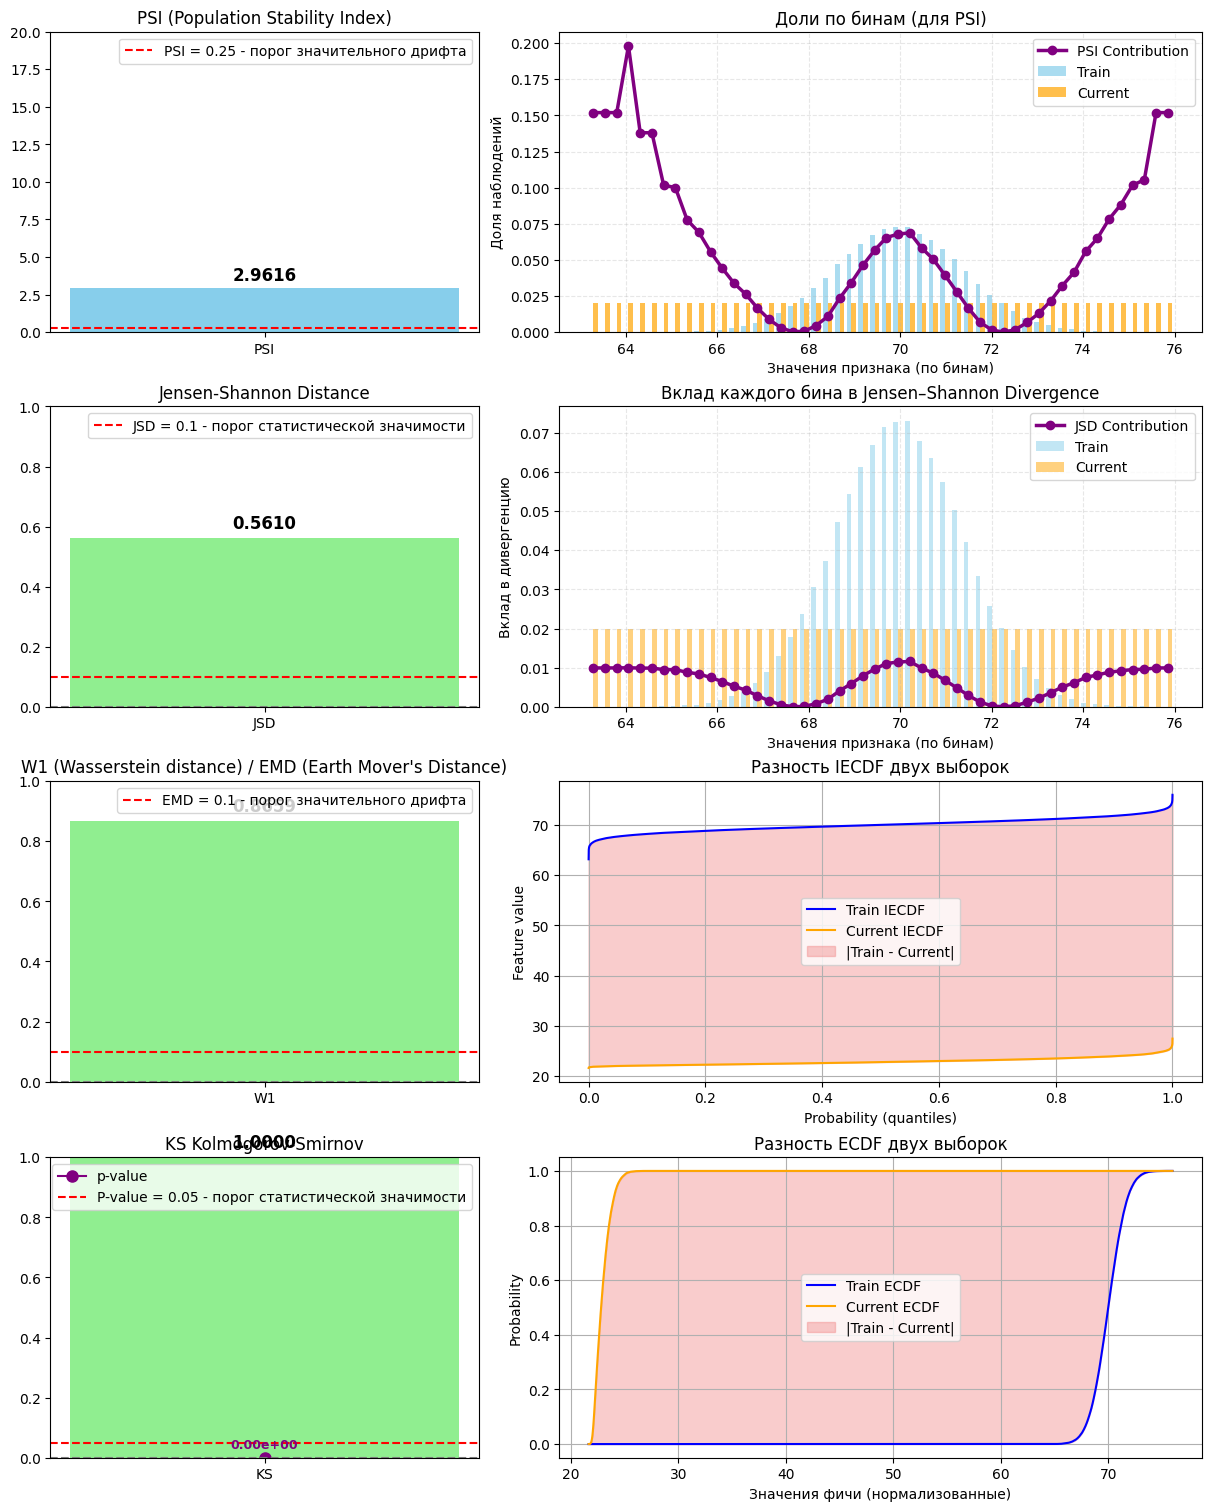